# 数据探索预处理

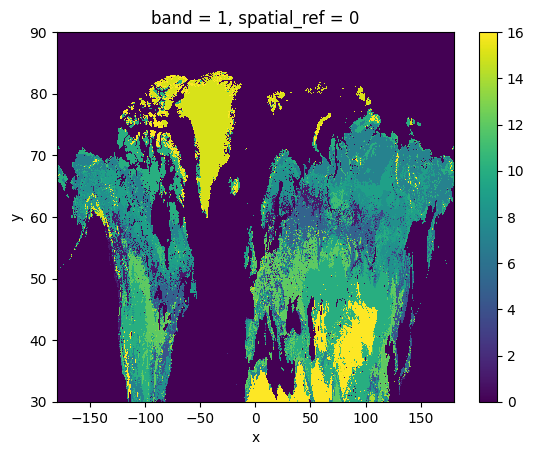

In [9]:
import rioxarray as rxr
import numpy as np
import matplotlib.pyplot as plt

landcover = rxr.open_rasterio('../data/lc_mode_30N.tif')
landcover.plot()


土地覆盖数据有点问题，因此我自己下载了

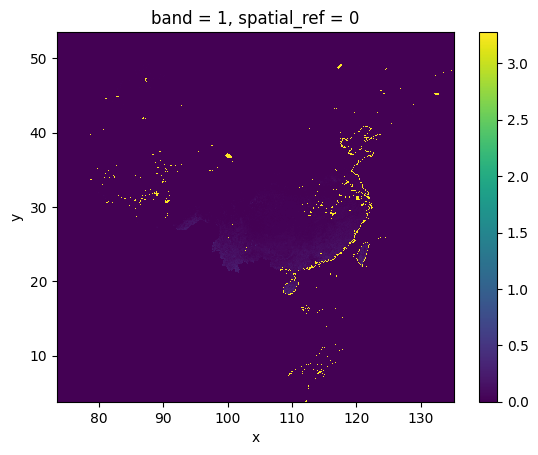

In [7]:
import rioxarray as rxr
import numpy as np
import matplotlib.pyplot as plt

# 读取数据
dstemp = rxr.open_rasterio('E:/data/GOSIF/gosif_china/gosif_2001001.tif')

# 数据处理：
# 1. 将小于0的值设置为0
# 2. 将32766异常值设置为NaN
# 3. 将所有数值除以10000
dstemp_processed = dstemp.copy()
dstemp_processed = dstemp_processed.where(dstemp_processed != 32766, np.nan)  # 将32766设为NaN
dstemp_processed = dstemp_processed.where(dstemp_processed >= 0, 0)  # 将小于0的值设为0
dstemp_processed = dstemp_processed / 10000  # 所有值除以10000

# 绘制处理后的数据

dstemp_processed.plot()



In [11]:
# 读取数据
dstemp = rxr.open_rasterio('E:/data/GOSIF/gosif_china/gosif_2001001.tif')

# 导出tif的四周边界shp
import geopandas as gpd
from shapely.geometry import box

minx, miny, maxx, maxy = dstemp.rio.bounds()

boundary_box = box(minx, miny, maxx, maxy)

boundary_gdf = gpd.GeoDataFrame(geometry=[boundary_box], crs=dstemp.rio.crs)

boundary_gdf = boundary_gdf.to_crs('EPSG:4326')

output_path = '../data/gosif_boundary.shp'
boundary_gdf.to_file(output_path)

print(f"边界shapefile已保存到: {output_path}")

边界shapefile已保存到: ../data/gosif_boundary.shp


In [1]:
import os
import ee
import geemap
os.environ['HTTP_PROXY'] = 'http://127.0.0.1:7890'
os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:7890'
Map = geemap.Map()
geemap.ee_initialize()

In [8]:
# 导入必要的库
import os
import ee
import geemap

# 定义输出路径
output_dir = '../data'
os.makedirs(output_dir, exist_ok=True)

# 加载MCD12产品
mcd12 = ee.ImageCollection("MODIS/061/MCD12Q1")

mcd12_2021 = mcd12.filter(ee.Filter.date('2021-01-01', '2021-12-31')).first()

# 选择LC_Type1波段(IGBP分类)
mcd12_lc_type1 = mcd12_2021.select('LC_Type1')
gosif_boundary = geemap.shp_to_ee('../data/gosif_boundary.shp')
mcd12_clipped = mcd12_lc_type1.clip(gosif_boundary)


# 下载裁剪后的影像
output_file = os.path.join(output_dir, 'MCD12_2021_LC_Type1.tif')
geemap.ee_export_image(mcd12_clipped, crs='epsg:4326', scale=5566, region=gosif_boundary.geometry(), filename=output_file)

print(f"MCD12 2021年土地覆盖数据已下载到: {output_file}")

# 可视化结果
Map.centerObject(gosif_boundary, 5)
Map.addLayer(mcd12_clipped, {'min': 1, 'max': 17, 'palette': 'Spectral'}, 'MCD12 2021 Land Cover')
Map


Generating URL ...
Please wait ...
Data downloaded to d:\Onedrive\GitHub\GOSIF_phenology\data\MCD12_2021_LC_Type1.tif
MCD12 2021年土地覆盖数据已下载到: ../data\MCD12_2021_LC_Type1.tif


Map(bottom=3737.0, center=[27.791252625314264, 104.29999999999959], controls=(WidgetControl(options=['position…

这里发现只有2021年的GOSIF维度不对，其余年都是（995 * 1232），而2021年是（995 * 1231）

In [15]:
import os
import glob
import numpy as np
import rasterio
from tqdm import tqdm

gosif_dir = r'E:\data\GOSIF\gosif_china'
output_dir = r'E:\data\GOSIF\gosif_2021new'
os.makedirs(output_dir, exist_ok=True)

# 获取2021年的所有tif文件
gosif_files_2021 = glob.glob(os.path.join(gosif_dir, 'gosif_2021*.tif'))


for file_path in tqdm(gosif_files_2021, desc="处理2021年文件"):
    with rasterio.open(file_path) as src:
        data = src.read()
        meta = src.meta.copy()
        
        file_name = os.path.basename(file_path)
        
        # 在最左边添加一列NaN值
        bands, height, width = data.shape
        
        # 创建新的数据数组，宽度+1
        new_data = np.zeros((bands, height, width + 1), dtype=data.dtype)
        
        # 在最左边填充NaN值
        if np.issubdtype(data.dtype, np.integer):
            if 'nodata' in meta:
                new_data[:, :, 0] = meta['nodata']
            else:
                new_data[:, :, 0] = 0  # 如果没有nodata值，使用0
        else:
            new_data[:, :, 0] = np.nan
        
        new_data[:, :, 1:] = data
        
        meta.update({
            'width': width + 1,
            'transform': rasterio.Affine(
                meta['transform'].a,
                meta['transform'].b,
                meta['transform'].c,
                meta['transform'].d,
                meta['transform'].e,
                meta['transform'].f 
            )
        })
        
        # 保存新文件
        output_path = os.path.join(output_dir, file_name)
        with rasterio.open(output_path, 'w', **meta) as dst:
            dst.write(new_data)

print(f"所有2021年文件处理完成，已保存到: {output_dir}")


处理2021年文件: 100%|██████████| 46/46 [00:00<00:00, 53.94it/s]

所有2021年文件处理完成，已保存到: E:\data\GOSIF\gosif_2021new


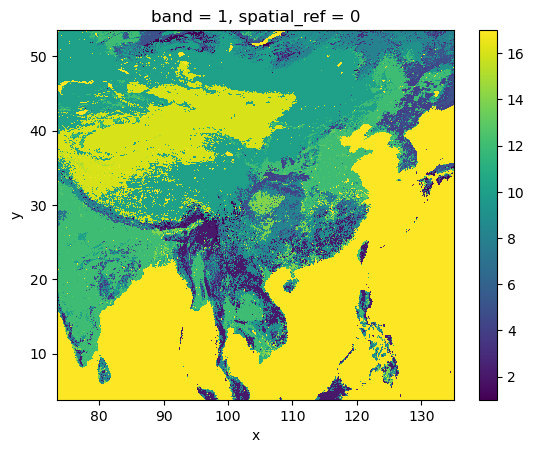

In [11]:
import rioxarray as rxr
import numpy as np
import matplotlib.pyplot as plt

# 读取数据
landcover = rxr.open_rasterio('../data/MCD12_2021_LC_Type1_trimmed.tif')
landcover.plot()


In [12]:
landcover.shape

(1, 995, 1232)

# 数据预处理

In [8]:
data[0, 0]

9.999999747378752e-05

In [12]:
import os
import numpy as np
import xarray as xr
import rioxarray as rxr
import glob
from tqdm import tqdm

# 定义路径
gosif_dir = r'E:\data\GOSIF\gosif_china'
lc_file = r'../data/MCD12_2021_LC_Type1_trimmed.tif'
output_dir = r'E:\data\GOSIF\gosif_china_processed'
os.makedirs(output_dir, exist_ok=True)

# 读取土地覆盖数据
lc_data = rxr.open_rasterio(lc_file, masked=True)
lc_mask = np.logical_and(lc_data.values[0] >= 1, lc_data.values[0] <= 11)

# 获取所有GOSIF文件
gosif_files = sorted(glob.glob(os.path.join(gosif_dir, 'gosif_*.tif')))

year_files = {}
for file in gosif_files:
    year = os.path.basename(file)[6:10]  # 提取年份信息
    if year not in year_files:
        year_files[year] = []
    year_files[year].append(file)

# 处理每一年的数据
for year, files in tqdm(year_files.items(), desc="处理年份"):
    print(f"正在处理 {year} 年数据...")
    
    # 1. 首先读取该年所有数据
    year_data_list = []
    time_values = []
    
    for file in tqdm(files, desc=f"读取{year}年文件"):
        data = rxr.open_rasterio(file, masked=True)
        year_data_list.append(data)
        time_values.append(os.path.basename(file)[6:13])
    
    # 2. 将数据合并为一个多维xarray - 直接指定维度名称为'time'
    year_dataset = xr.concat(year_data_list, dim='time')
    
    # 设置时间坐标
    year_dataset = year_dataset.assign_coords({'time': time_values})
    
    # 3. 应用mask：土地覆盖mask和异常值mask
    data_array = year_dataset.values
    
    for i in range(data_array.shape[0]):
        data_array[i, 0] = np.where(lc_mask, data_array[i, 0], np.nan)
        data_array[i, 0] = np.where(data_array[i, 0] == 32766, np.nan, data_array[i, 0])
    
    year_dataset.values = data_array
    
    # 4. 数值除以10000
    year_dataset = year_dataset / 10000.0
    
    # 5. 为每个像素计算时间序列中大于0的最小值
    # 创建一个掩码，表示哪些值大于0
    positive_data = year_dataset.where(year_dataset > 0)
    
    # 沿时间轴找出每个像素位置的最小非NaN值
    min_positive = positive_data.min(dim='time')
    
    # 对于完全没有正值的像素，设置一个默认的最小正值
    min_positive_array = min_positive.values[0].copy()
    min_positive_array = np.where(np.isnan(min_positive_array), 0.0001, min_positive_array)
    
    print(f"{year}年处理统计:")
    print(f"  有效像素百分比: {np.sum(~np.isnan(min_positive_array))/min_positive_array.size:.2%}")
    print(f"  最小正值范围: {np.nanmin(min_positive_array):.6f} - {np.nanmax(min_positive_array):.6f}")
    
    # 6. 将小于0的值替换为该像素点在当年时间序列中大于0的最小值
    for i in tqdm(range(len(files)), desc=f"处理{year}年文件"):
        file = files[i]
        output_file = os.path.join(output_dir, os.path.basename(file))
        
        current_data = year_dataset.isel(time=i).copy()
        data_values = current_data.values[0]
        
        data_values = np.where(np.logical_and(~np.isnan(data_values), data_values < 0), 
                              min_positive_array, data_values)

        current_data.values[0] = data_values
        
        current_data.rio.to_raster(output_file, dtype="float32")
    
    print(f"{year}年数据处理完成")

print("所有GOSIF数据预处理完成！")

处理年份:   0%|          | 0/21 [00:00<?, ?it/s]

正在处理 2001 年数据...


读取2001年文件: 100%|██████████| 46/46 [00:00<00:00, 209.75it/s]


2001年处理统计:
  有效像素百分比: 100.00%
  最小正值范围: 0.000100 - 3.276700


处理年份:   5%|▍         | 1/21 [00:02<00:53,  2.67s/it]

2001年数据处理完成
正在处理 2002 年数据...


读取2002年文件: 100%|██████████| 46/46 [00:00<00:00, 162.90it/s]


2002年处理统计:
  有效像素百分比: 100.00%
  最小正值范围: 0.000100 - 3.276700


处理年份:  10%|▉         | 2/21 [00:05<00:51,  2.73s/it]

2002年数据处理完成
正在处理 2003 年数据...


读取2003年文件: 100%|██████████| 46/46 [00:00<00:00, 175.23it/s]


2003年处理统计:
  有效像素百分比: 100.00%
  最小正值范围: 0.000100 - 3.276700


处理年份:  14%|█▍        | 3/21 [00:08<00:50,  2.78s/it]

2003年数据处理完成
正在处理 2004 年数据...


读取2004年文件: 100%|██████████| 46/46 [00:00<00:00, 174.57it/s]


2004年处理统计:
  有效像素百分比: 100.00%
  最小正值范围: 0.000100 - 3.276700


处理年份:  19%|█▉        | 4/21 [00:11<00:47,  2.82s/it]

2004年数据处理完成
正在处理 2005 年数据...


读取2005年文件: 100%|██████████| 46/46 [00:00<00:00, 176.16it/s]


2005年处理统计:
  有效像素百分比: 100.00%
  最小正值范围: 0.000100 - 3.276700


处理年份:  24%|██▍       | 5/21 [00:14<00:46,  2.88s/it]

2005年数据处理完成
正在处理 2006 年数据...


读取2006年文件: 100%|██████████| 46/46 [00:00<00:00, 166.36it/s]


2006年处理统计:
  有效像素百分比: 100.00%
  最小正值范围: 0.000100 - 3.276700


处理年份:  29%|██▊       | 6/21 [00:17<00:47,  3.14s/it]

2006年数据处理完成
正在处理 2007 年数据...


读取2007年文件: 100%|██████████| 46/46 [00:00<00:00, 149.97it/s]


2007年处理统计:
  有效像素百分比: 100.00%
  最小正值范围: 0.000100 - 3.276700


处理年份:  33%|███▎      | 7/21 [00:21<00:47,  3.37s/it]

2007年数据处理完成
正在处理 2008 年数据...


读取2008年文件: 100%|██████████| 46/46 [00:00<00:00, 194.34it/s]


2008年处理统计:
  有效像素百分比: 100.00%
  最小正值范围: 0.000100 - 3.276700


处理年份:  38%|███▊      | 8/21 [00:24<00:43,  3.31s/it]

2008年数据处理完成
正在处理 2009 年数据...


读取2009年文件: 100%|██████████| 46/46 [00:00<00:00, 128.50it/s]


2009年处理统计:
  有效像素百分比: 100.00%
  最小正值范围: 0.000100 - 3.276700


处理年份:  43%|████▎     | 9/21 [00:29<00:44,  3.69s/it]

2009年数据处理完成
正在处理 2010 年数据...


读取2010年文件: 100%|██████████| 46/46 [00:00<00:00, 169.13it/s]


2010年处理统计:
  有效像素百分比: 100.00%
  最小正值范围: 0.000100 - 3.276700


处理年份:  48%|████▊     | 10/21 [00:32<00:39,  3.63s/it]

2010年数据处理完成
正在处理 2011 年数据...


读取2011年文件: 100%|██████████| 46/46 [00:00<00:00, 185.33it/s]


2011年处理统计:
  有效像素百分比: 100.00%
  最小正值范围: 0.000100 - 3.276700


处理年份:  52%|█████▏    | 11/21 [00:44<01:00,  6.01s/it]

2011年数据处理完成
正在处理 2012 年数据...


读取2012年文件: 100%|██████████| 46/46 [00:00<00:00, 185.78it/s]


2012年处理统计:
  有效像素百分比: 100.00%
  最小正值范围: 0.000100 - 3.276700


处理年份:  57%|█████▋    | 12/21 [00:47<00:46,  5.15s/it]

2012年数据处理完成
正在处理 2013 年数据...


读取2013年文件: 100%|██████████| 46/46 [00:00<00:00, 175.76it/s]


2013年处理统计:
  有效像素百分比: 100.00%
  最小正值范围: 0.000100 - 3.276700


处理年份:  62%|██████▏   | 13/21 [00:50<00:35,  4.46s/it]

2013年数据处理完成
正在处理 2014 年数据...


读取2014年文件: 100%|██████████| 46/46 [00:00<00:00, 146.13it/s]


2014年处理统计:
  有效像素百分比: 100.00%
  最小正值范围: 0.000100 - 3.276700


处理年份:  67%|██████▋   | 14/21 [00:53<00:29,  4.23s/it]

2014年数据处理完成
正在处理 2015 年数据...


读取2015年文件: 100%|██████████| 46/46 [00:00<00:00, 187.16it/s]


2015年处理统计:
  有效像素百分比: 100.00%
  最小正值范围: 0.000100 - 3.276700


处理年份:  71%|███████▏  | 15/21 [00:57<00:24,  4.02s/it]

2015年数据处理完成
正在处理 2016 年数据...


读取2016年文件: 100%|██████████| 46/46 [00:00<00:00, 161.49it/s]


2016年处理统计:
  有效像素百分比: 100.00%
  最小正值范围: 0.000100 - 3.276700


处理年份:  76%|███████▌  | 16/21 [01:01<00:19,  3.87s/it]

2016年数据处理完成
正在处理 2017 年数据...


读取2017年文件: 100%|██████████| 46/46 [00:00<00:00, 158.81it/s]


2017年处理统计:
  有效像素百分比: 100.00%
  最小正值范围: 0.000100 - 3.276700


处理年份:  81%|████████  | 17/21 [01:05<00:16,  4.05s/it]

2017年数据处理完成
正在处理 2018 年数据...


读取2018年文件: 100%|██████████| 46/46 [00:00<00:00, 175.26it/s]


2018年处理统计:
  有效像素百分比: 100.00%
  最小正值范围: 0.000100 - 3.276700


处理年份:  86%|████████▌ | 18/21 [01:09<00:12,  4.02s/it]

2018年数据处理完成
正在处理 2019 年数据...


读取2019年文件: 100%|██████████| 46/46 [00:00<00:00, 146.51it/s]


2019年处理统计:
  有效像素百分比: 100.00%
  最小正值范围: 0.000100 - 3.276700


处理年份:  90%|█████████ | 19/21 [01:12<00:07,  3.85s/it]

2019年数据处理完成
正在处理 2020 年数据...


读取2020年文件: 100%|██████████| 46/46 [00:00<00:00, 176.49it/s]


2020年处理统计:
  有效像素百分比: 100.00%
  最小正值范围: 0.000100 - 3.276700


处理年份:  95%|█████████▌| 20/21 [01:18<00:04,  4.46s/it]

2020年数据处理完成
正在处理 2021 年数据...


读取2021年文件: 100%|██████████| 46/46 [00:00<00:00, 133.74it/s]


2021年处理统计:
  有效像素百分比: 100.00%
  最小正值范围: 0.000100 - 3.276700


处理年份: 100%|██████████| 21/21 [01:22<00:00,  3.92s/it]

2021年数据处理完成
所有GOSIF数据预处理完成！


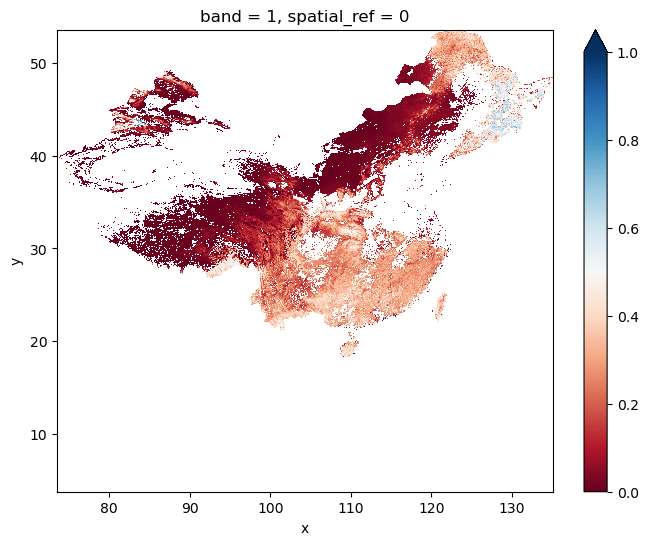

In [13]:
import rioxarray as rxr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize


da = rxr.open_rasterio('E:/data/GOSIF/gosif_china_processed/gosif_2001161.tif')
plt.figure(figsize=(8, 6))
da.plot(cmap='RdBu', norm=Normalize(vmin=0, vmax=1))

找到 966 个文件
找到 222063 个非NaN像素点
正在加载所有数据...


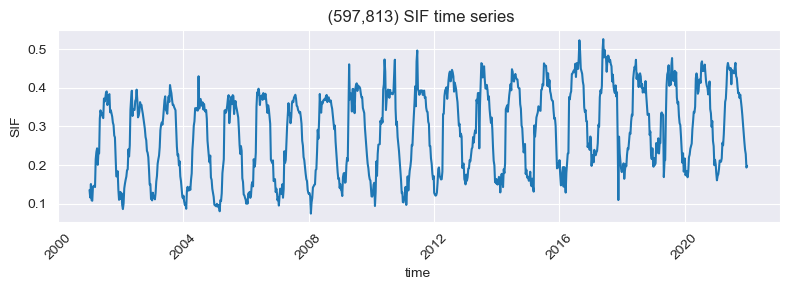

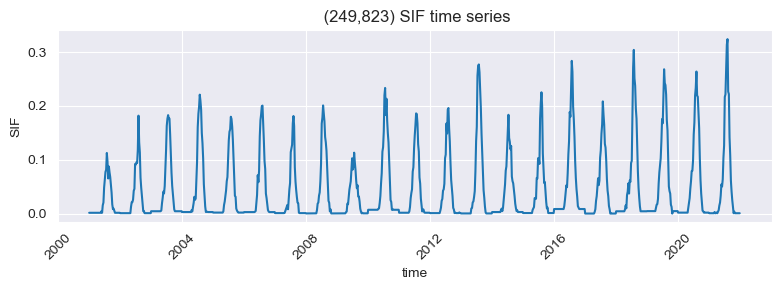

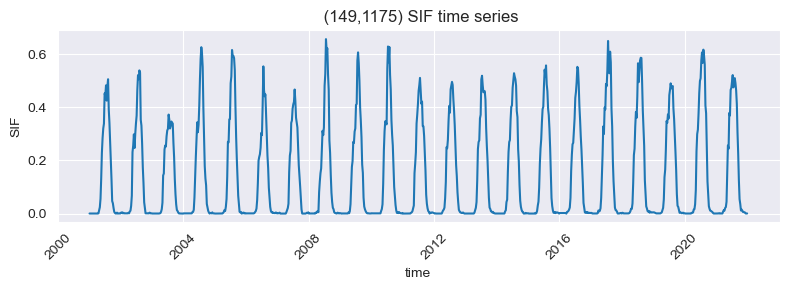

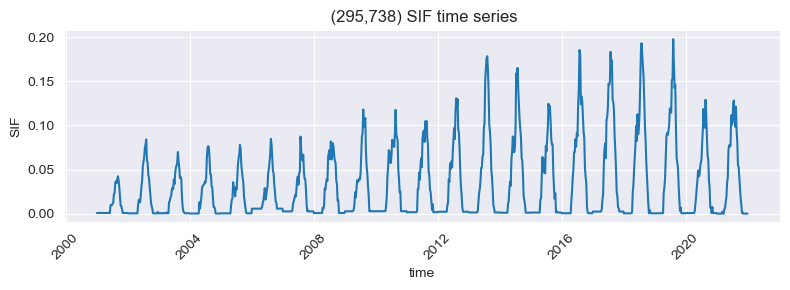

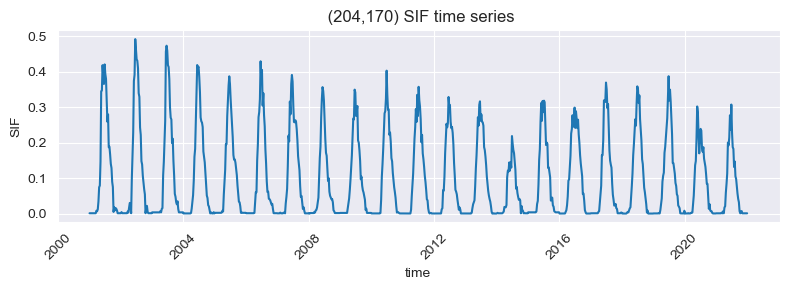

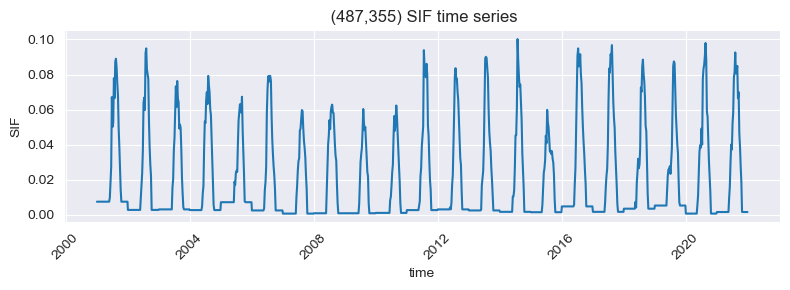

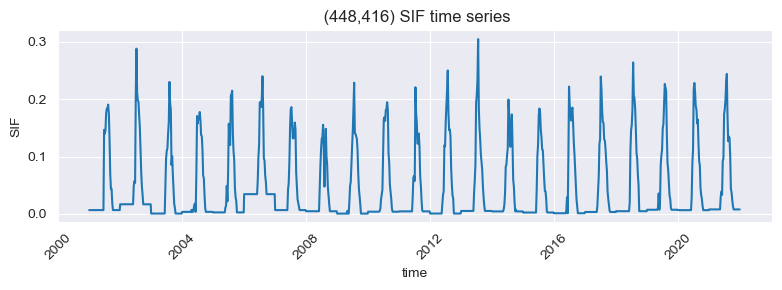

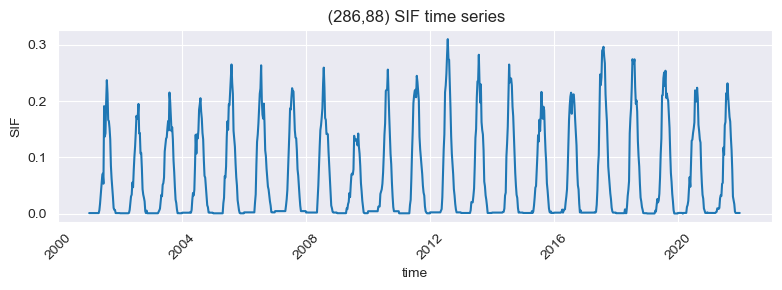

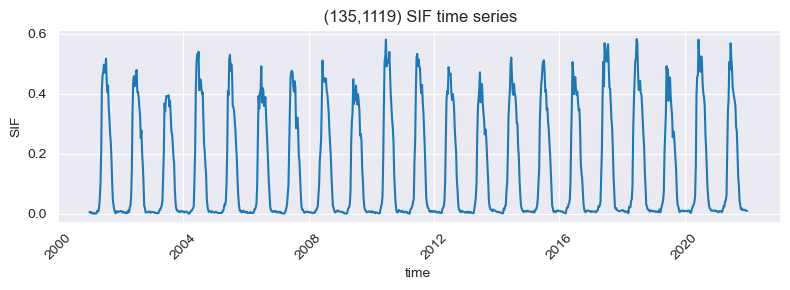

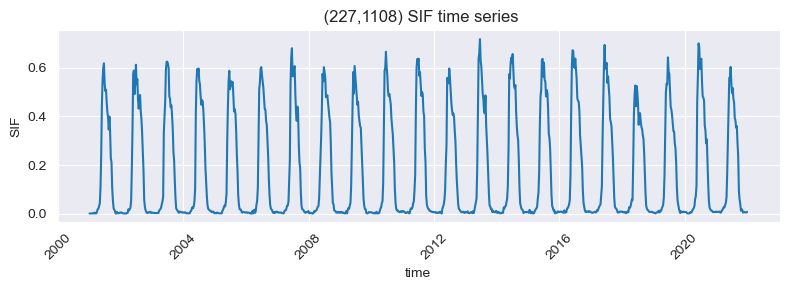

In [3]:
import glob
import numpy as np
import rioxarray as rxr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


np.random.seed(42)
gosif_files = sorted(glob.glob('E:/data/GOSIF/gosif_china_processed/gosif_*.tif'))
print(f"找到 {len(gosif_files)} 个文件")

dates = [datetime.strptime(f.split('\\')[-1][6:13], '%Y%j') for f in gosif_files]
first_data = rxr.open_rasterio(gosif_files[0], masked=True)
height, width = first_data.shape[1], first_data.shape[2]
mask = ~np.isnan(first_data.values[0])

# 获取所有非NaN像素的坐标
y_indices, x_indices = np.where(mask)
valid_count = len(y_indices)
print(f"找到 {valid_count} 个非NaN像素点")

# 加载所有数据到一个3D array (时间, 高度, 宽度)
print("正在加载所有数据...")
all_data = np.full((len(gosif_files), height, width), np.nan)
for i, file in enumerate(gosif_files):
    all_data[i] = rxr.open_rasterio(file, masked=True).values[0]

# 随机选择10个有效像素点绘图
selected_indices = np.random.choice(valid_count, min(10, valid_count), replace=False)
selected_y = y_indices[selected_indices]
selected_x = x_indices[selected_indices]

sns.set_style("darkgrid")
for i, (y, x) in enumerate(zip(selected_y, selected_x)):
    # 提取该点的时间序列
    time_series = all_data[:, y, x]
    df = pd.DataFrame({"SIF": time_series}, index=dates)
    plt.figure(figsize=(8, 3))
    sns.lineplot(data=df, x=df.index, y="SIF")
    plt.title(f' ({y},{x}) SIF time series')
    plt.xlabel('time')
    plt.ylabel('SIF')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    

# SG滤波

找到 966 个8天间隔的文件
原始8天间隔数据点: 966
新的4天间隔数据点: 1917
数据包含 21 个年份: [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
正在加载数据到3D矩阵...


100%|██████████| 966/966 [00:12<00:00, 76.78it/s]


创建输出矩阵...
开始处理所有像素...


100%|██████████| 995/995 [27:27<00:00,  1.66s/it] 


保存结果...


100%|██████████| 1917/1917 [01:48<00:00, 17.61it/s]
C:\Users\DELL\AppData\Local\Temp\ipykernel_7808\2377135359.py:197: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  plt.tight_layout()
C:\Users\DELL\AppData\Local\Temp\ipykernel_7808\2377135359.py:197: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from current font.
  plt.tight_layout()
C:\Users\DELL\AppData\Local\Temp\ipykernel_7808\2377135359.py:197: UserWarning: Glyph 32032 (\N{CJK UNIFIED IDEOGRAPH-7D20}) missing from current font.
  plt.tight_layout()
C:\Users\DELL\AppData\Local\Temp\ipykernel_7808\2377135359.py:197: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9}) missing from current font.
  plt.tight_layout()
C:\Users\DELL\AppData\Local\Temp\ipykernel_7808\2377135359.py:197: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  plt.tight_layout()
C:\Users\DELL\AppData\Local\Temp\ipykernel_7808\2377135359.py:197: UserWarning: Gly

处理完成!
绘制样本点比较图...


C:\Users\DELL\AppData\Local\Temp\ipykernel_7808\2377135359.py:197: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
C:\Users\DELL\AppData\Local\Temp\ipykernel_7808\2377135359.py:197: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.tight_layout()
C:\Users\DELL\AppData\Local\Temp\ipykernel_7808\2377135359.py:198: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  plt.savefig('sg_interpolation_fixed_window.png', dpi=300)
C:\Users\DELL\AppData\Local\Temp\ipykernel_7808\2377135359.py:198: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from current font.
  plt.savefig('sg_interpolation_fixed_window.png', dpi=300)
C:\Users\DELL\AppData\Local\Temp\ipykernel_7808\2377135359.py:198: UserWarning: Glyph 32032 (\N{CJK UNIFIED IDEOGRAPH-7D20}) missing from current font.
  plt.savefig('sg_interpolation_fixed_window.png', dpi=300)
C:\Users\DELL\AppD

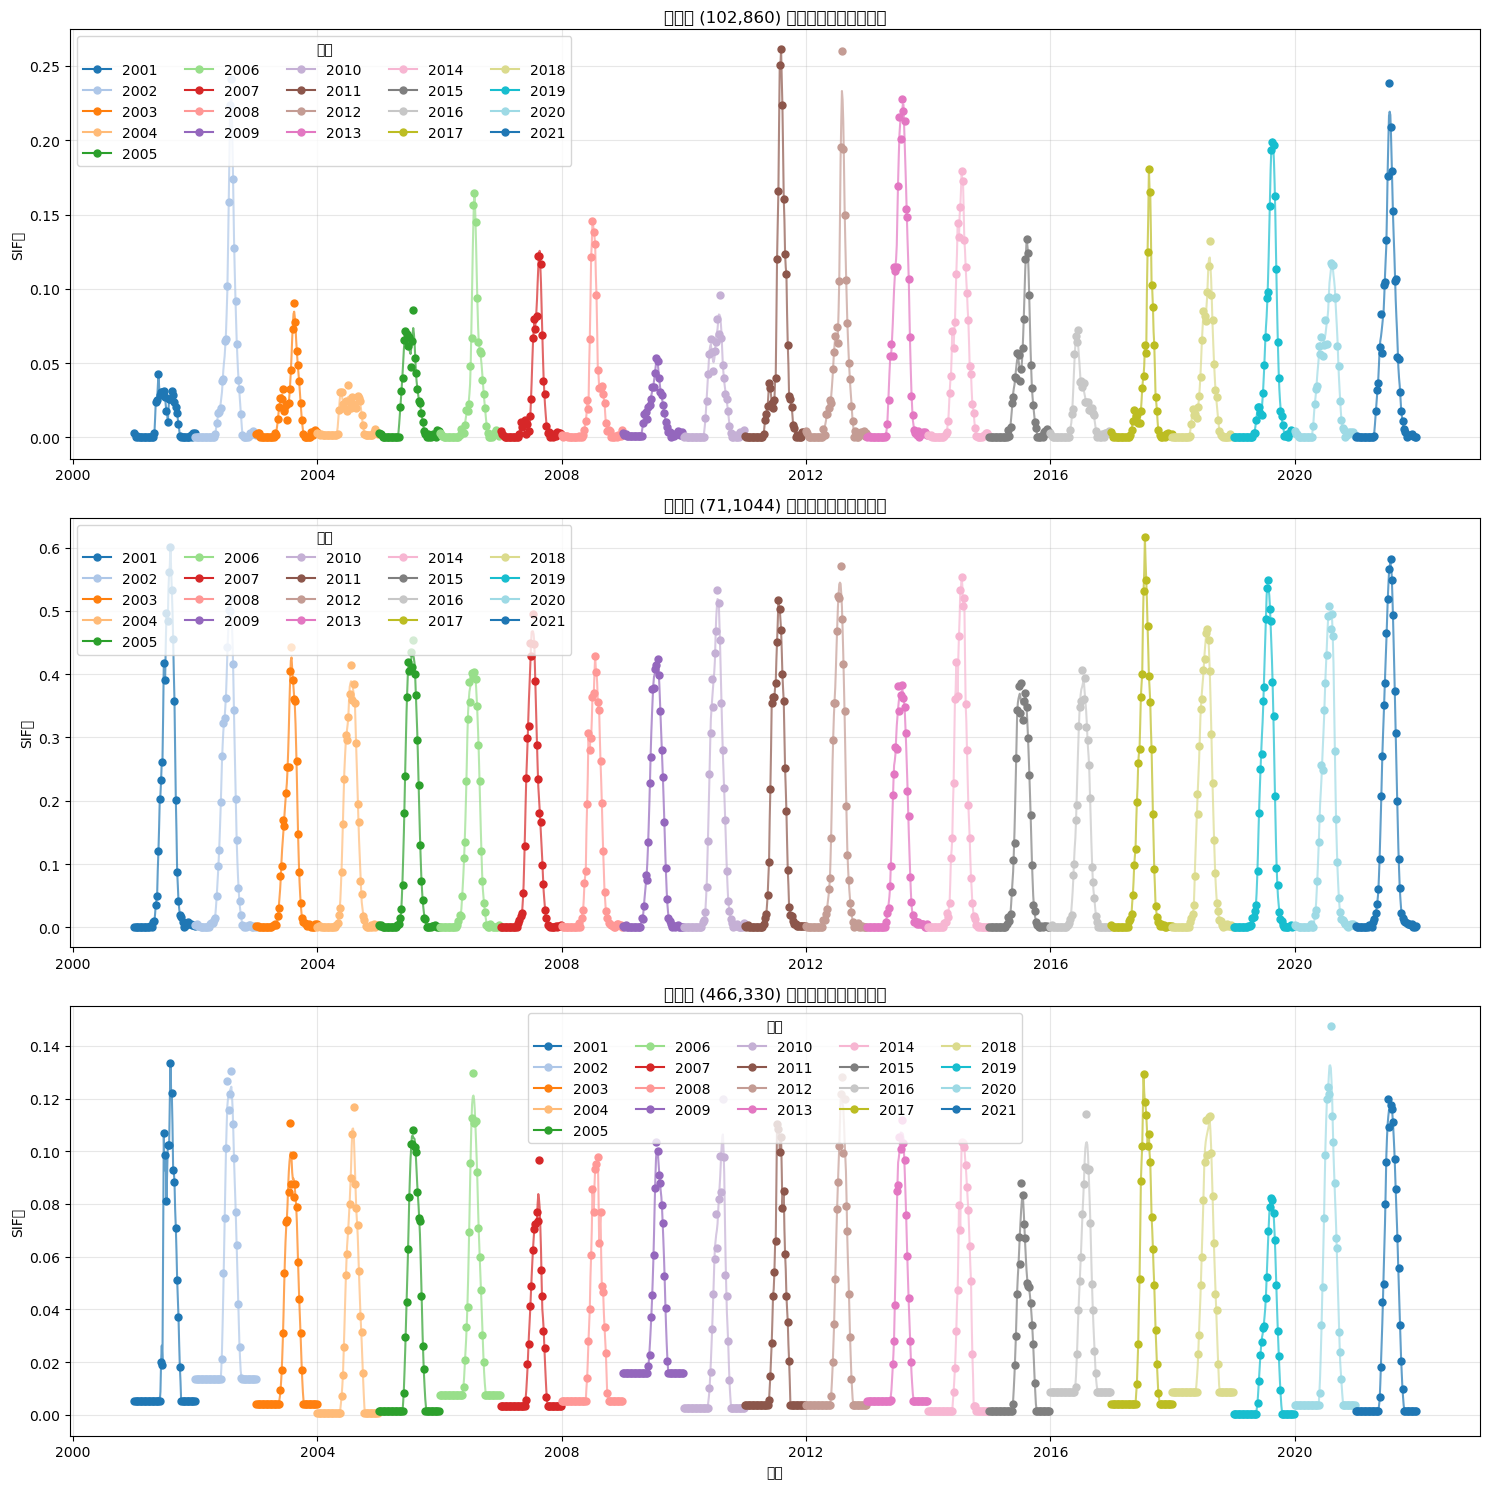

In [1]:
import os
import glob
import numpy as np
import rioxarray as rxr
from scipy.signal import savgol_filter
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from scipy.interpolate import interp1d

# 输入和输出目录
input_dir = 'E:/data/GOSIF/gosif_china_processed'
output_dir = 'E:/data/GOSIF/gosif_china_4day'
os.makedirs(output_dir, exist_ok=True)

# 获取所有8天间隔的文件
gosif_files = sorted(glob.glob(os.path.join(input_dir, 'gosif_*.tif')))
print(f"找到 {len(gosif_files)} 个8天间隔的文件")

# 创建日期
dates_8day = []
for file in gosif_files:
    filename = os.path.basename(file)
    year = int(filename[6:10])
    day = int(filename[10:13])
    date = datetime(year, 1, 1) + timedelta(days=day-1)
    dates_8day.append(date)

# 创建新的4天间隔
start_date = dates_8day[0]
end_date = dates_8day[-1]
dates_4day = []
current_date = start_date
while current_date <= end_date:
    dates_4day.append(current_date)
    current_date += timedelta(days=4)

print(f"原始8天间隔数据点: {len(dates_8day)}")
print(f"新的4天间隔数据点: {len(dates_4day)}")
years = sorted(list(set([d.year for d in dates_8day])))
print(f"数据包含 {len(years)} 个年份: {years}")

# 读取元数据维度
template = rxr.open_rasterio(gosif_files[0])
height, width = template.shape[1], template.shape[2]

print("正在加载数据到3D矩阵...")
data_3d = np.full((len(gosif_files), height, width), np.nan)
for i, file in tqdm(enumerate(gosif_files), total=len(gosif_files)):
    data_3d[i] = rxr.open_rasterio(file, masked=True).values[0]

days_8day = np.array([(date - start_date).days for date in dates_8day])
days_4day = np.array([(date - start_date).days for date in dates_4day])

print("创建输出矩阵...")
data_4day = np.full((len(dates_4day), height, width), np.nan)

# SG滤波窗口为5，多项式阶数为2
window_length = 5
polyorder = 2

# 逐像素处理
for y in tqdm(range(height)):
    for x in range(width):
        # 提取该像素的时间序列
        pixel_data = data_3d[:, y, x]

        if np.all(np.isnan(pixel_data)):
            continue  # 如果全是NaN，跳过此像素
        
        # 按年份分别处理
        for year in years:
            # 获取当前年份的日期索引和数据
            year_indices_8day = [i for i, d in enumerate(dates_8day) if d.year == year]
            year_days_8day = days_8day[year_indices_8day]
            year_data_8day = pixel_data[year_indices_8day]
            
            # 找出当前年份对应的4天间隔的索引
            year_indices_4day = [i for i, d in enumerate(dates_4day) if d.year == year]
            year_days_4day = days_4day[year_indices_4day]
            
            valid_mask = ~np.isnan(year_data_8day)
            valid_days = year_days_8day[valid_mask]
            valid_data = year_data_8day[valid_mask]
            
            if len(valid_data) < window_length:
                continue
            
            try:
                # SG滤波平滑数据
                smoothed_data = savgol_filter(valid_data, window_length, polyorder)
                
                # 将SG滤波结果插值到4天
                f_interp = interp1d(valid_days, smoothed_data, kind='linear', bounds_error=False, fill_value=np.nan)
                interpolated_values = f_interp(year_days_4day)
                
                # 保存插值结果
                for j, idx_4day in enumerate(year_indices_4day):
                    data_4day[idx_4day, y, x] = interpolated_values[j]
            except Exception as e:
                # 如果SG滤波或插值失败，尝试直接线性插值
                try:
                    f_linear = interp1d(valid_days, valid_data, kind='linear', bounds_error=False, fill_value=np.nan)
                    interpolated_values = f_linear(year_days_4day)
                    for j, idx_4day in enumerate(year_indices_4day):
                        data_4day[idx_4day, y, x] = interpolated_values[j]
                except:
                    # 如果都失败，跳过
                    continue

# 确保原始8天数据点的值保持不变（如果有的话）
for i, date_8day in enumerate(dates_8day):
    if date_8day in dates_4day:
        idx_4day = dates_4day.index(date_8day)
        non_nan_mask = ~np.isnan(data_3d[i])
        data_4day[idx_4day][non_nan_mask] = data_3d[i][non_nan_mask]

# 将结果保存为新的tif文件
print("保存结果...")
for i, date in tqdm(enumerate(dates_4day), total=len(dates_4day)):
    # 创建文件名: gosif_YYYYDDD.tif
    year = date.year
    day_of_year = (date - datetime(year, 1, 1)).days + 1
    filename = f"gosif_{year}{day_of_year:03d}.tif"
    output_path = os.path.join(output_dir, filename)
    
    # 创建新的栅格
    output_data = data_4day[i].copy()
    output_raster = template.copy()
    output_raster.values[0] = output_data

    output_raster.rio.to_raster(output_path)

print("处理完成!")

# 随机选择3个点进行可视化
print("绘制样本点比较图...")
np.random.seed(42)
# 随机选择3个非全NaN的点
valid_points = []
attempts = 0
while len(valid_points) < 3 and attempts < 100:
    y = np.random.randint(0, height)
    x = np.random.randint(0, width)
    pixel_data = data_3d[:, y, x]
    if not np.all(np.isnan(pixel_data)):
        valid_points.append((y, x))
    attempts += 1

plt.figure(figsize=(15, 15))
for i, (y, x) in enumerate(valid_points):
    plt.subplot(3, 1, i+1)
    
    # 按年份不同颜色绘制数据
    for j, year in enumerate(years):
        year_color = plt.cm.tab20(j % 20)
        
        # 获取该年份的数据
        year_indices_8day = [i for i, d in enumerate(dates_8day) if d.year == year]
        year_indices_4day = [i for i, d in enumerate(dates_4day) if d.year == year]
        
        year_dates_8day = [dates_8day[i] for i in year_indices_8day]
        year_data_8day = [data_3d[i, y, x] for i in year_indices_8day]
        
        year_dates_4day = [dates_4day[i] for i in year_indices_4day]
        year_data_4day = [data_4day[i, y, x] for i in year_indices_4day]
        
        # 绘制原始8天数据和插值后的4天数据
        plt.plot(year_dates_4day, year_data_4day, '-', color=year_color, alpha=0.7, linewidth=1.5)
        plt.plot(year_dates_8day, year_data_8day, 'o', color=year_color, markersize=5)
    
    plt.title(f'像素点 ({y},{x}) 的原始和插值数据比较')
    plt.ylabel('SIF值')
    plt.grid(True, alpha=0.3)
    
    # 添加图例说明颜色代表的年份
    handles = [plt.Line2D([0], [0], color=plt.cm.tab20(j % 20), marker='o', linestyle='-', markersize=5) 
               for j in range(len(years))]
    plt.legend(handles, [str(year) for year in years], title='年份', loc='best', ncol=min(5, len(years)))
    
    if i == len(valid_points) - 1:  # 最后一个子图添加x轴标签
        plt.xlabel('日期')

plt.tight_layout()
plt.savefig('sg_interpolation_fixed_window.png', dpi=300)
plt.show()

找到 966 个原始8天数据文件
找到 1917 个插值4天数据文件
寻找有效像素点...


100%|██████████| 5/5 [00:00<00:00, 72.64it/s]


找到并选择了 10 个有效像素点
读取原始8天数据...


100%|██████████| 966/966 [00:11<00:00, 83.96it/s]


读取插值4天数据...


100%|██████████| 1917/1917 [00:22<00:00, 86.95it/s]


绘制结果...


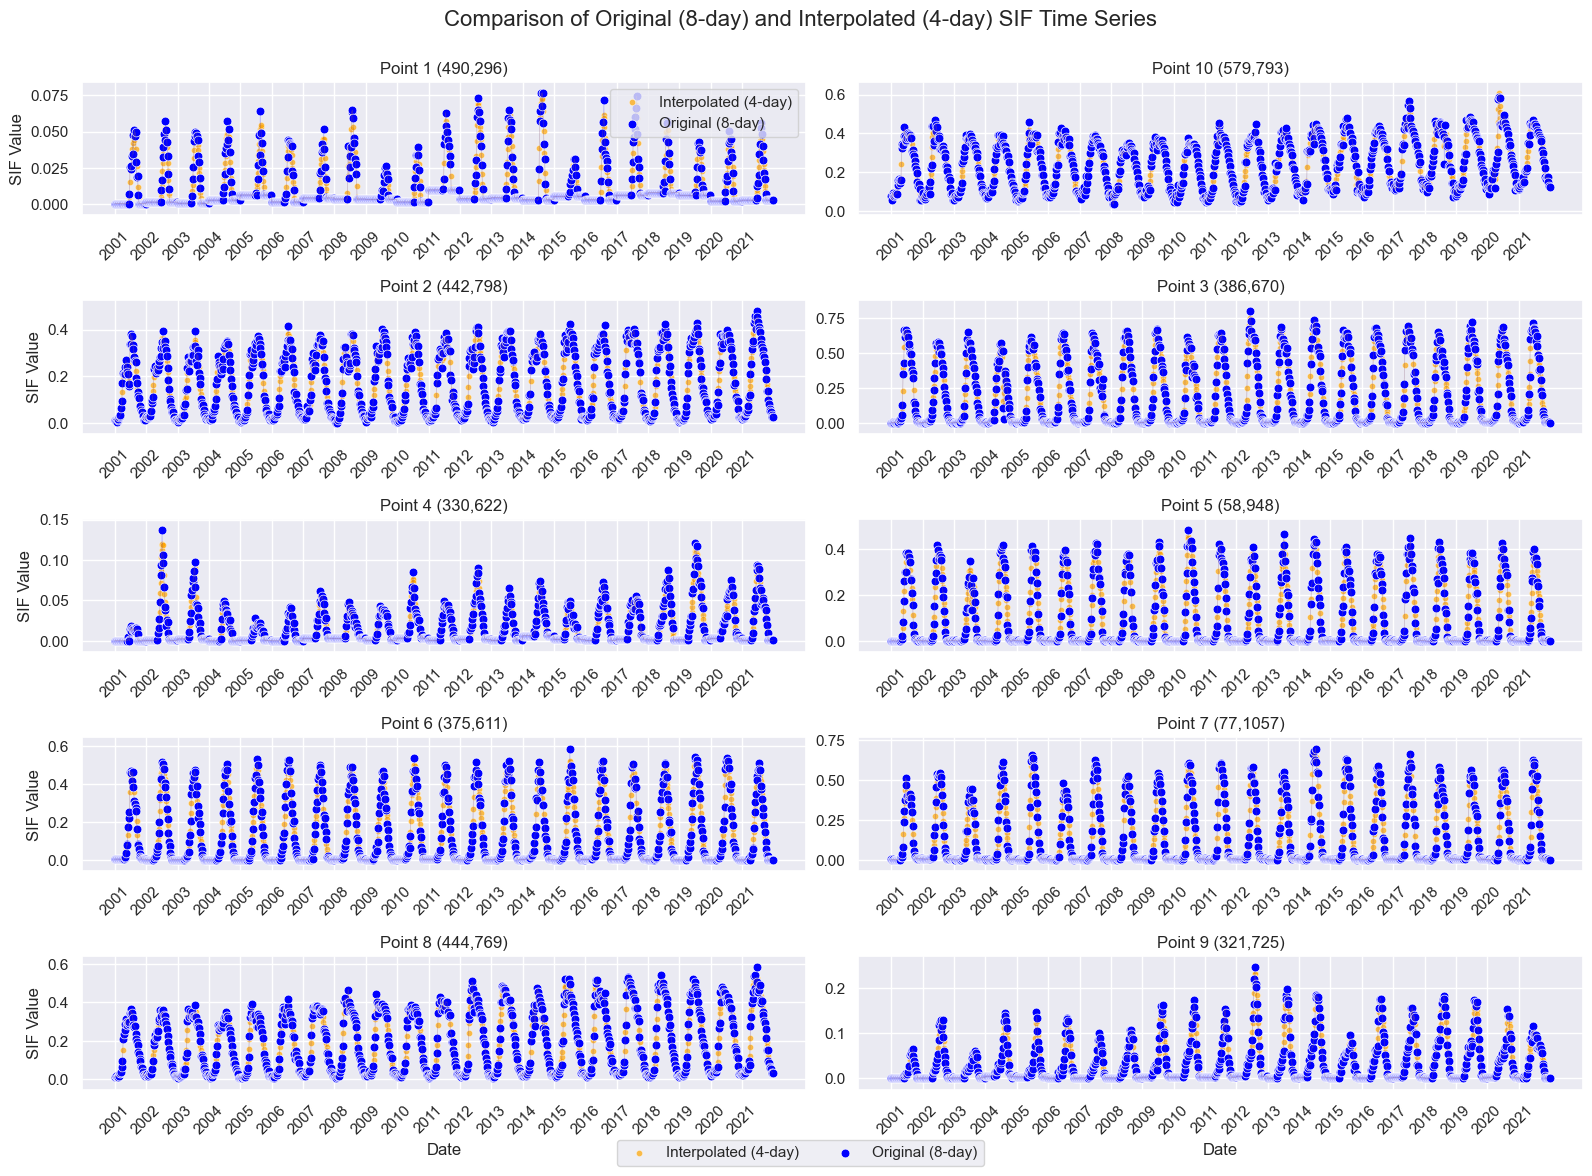

In [4]:
import os
import glob
import numpy as np
import rioxarray as rxr
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from tqdm import tqdm
import pandas as pd
import random
import math

sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12


original_dir = 'E:/data/GOSIF/gosif_china_processed'
interpolated_dir = 'E:/data/GOSIF/gosif_china_4day'

original_files = sorted(glob.glob(os.path.join(original_dir, 'gosif_*.tif')))
interpolated_files = sorted(glob.glob(os.path.join(interpolated_dir, 'gosif_*.tif')))

print(f"找到 {len(original_files)} 个原始8天数据文件")
print(f"找到 {len(interpolated_files)} 个插值4天数据文件")

# 创建日期列表
original_dates = []
for file in original_files:
    filename = os.path.basename(file)
    year = int(filename[6:10])
    day = int(filename[10:13])
    date = datetime(year, 1, 1) + timedelta(days=day-1)
    original_dates.append(date)

interpolated_dates = []
for file in interpolated_files:
    filename = os.path.basename(file)
    year = int(filename[6:10])
    day = int(filename[10:13])
    date = datetime(year, 1, 1) + timedelta(days=day-1)
    interpolated_dates.append(date)

# 读取第一个文件获取空间维度
template = rxr.open_rasterio(original_files[0])
height, width = template.shape[1], template.shape[2]

# 随机选择10个点进行可视化
random.seed(42)  # 设置随机种子以便结果可复现
valid_points = []
num_points = 10

print("寻找有效像素点...")

sample_files = random.sample(original_files, min(5, len(original_files)))

valid_mask = np.full((height, width), False)

for file in tqdm(sample_files):
    data = rxr.open_rasterio(file, masked=True).values[0]
    valid_mask = valid_mask | ~np.isnan(data)

# 获取有效像素的坐标
valid_y, valid_x = np.where(valid_mask)
if len(valid_y) > 0:
    # 随机选择10个有效点
    indices = np.random.choice(len(valid_y), min(num_points, len(valid_y)), replace=False)
    valid_points = [(valid_y[i], valid_x[i]) for i in indices]
else:
    print("未找到有效像素点！")
    exit(1)

print(f"找到并选择了 {len(valid_points)} 个有效像素点")

original_data = []
interpolated_data = []

# 读取原始数据的时间序列
print("读取原始8天数据...")
for i, file in tqdm(enumerate(original_files), total=len(original_files)):
    data = rxr.open_rasterio(file, masked=True).values[0]
    date = original_dates[i]
    
    for j, (y, x) in enumerate(valid_points):
        if y < data.shape[0] and x < data.shape[1]:  # 确保坐标在范围内
            value = data[y, x]
            if not np.isnan(value):
                original_data.append({
                    'Date': date,
                    'Value': value,
                    'Point': f'Point {j+1} ({y},{x})',
                    'Type': 'Original (8-day)'
                })

# 读取插值数据的时间序列
print("读取插值4天数据...")
for i, file in tqdm(enumerate(interpolated_files), total=len(interpolated_files)):
    data = rxr.open_rasterio(file, masked=True).values[0]
    date = interpolated_dates[i]
    
    for j, (y, x) in enumerate(valid_points):
        if y < data.shape[0] and x < data.shape[1]:  # 确保坐标在范围内
            value = data[y, x]
            if not np.isnan(value):
                interpolated_data.append({
                    'Date': date,
                    'Value': value,
                    'Point': f'Point {j+1} ({y},{x})',
                    'Type': 'Interpolated (4-day)'
                })

df_original = pd.DataFrame(original_data)
df_interpolated = pd.DataFrame(interpolated_data)
df = pd.concat([df_original, df_interpolated])

# 绘制结果
print("绘制结果...")
for i, point in enumerate(sorted(df['Point'].unique())):
    plt.figure(figsize=(14, 6))
    
    point_data = df[df['Point'] == point]
    
    sns.scatterplot(
        data=point_data[point_data['Type'] == 'Interpolated (4-day)'],
        x='Date', y='Value',
        color='orange', alpha=0.7, s=30,
        label='Interpolated (4-day)'
    )
    
    sns.scatterplot(
        data=point_data[point_data['Type'] == 'Original (8-day)'],
        x='Date', y='Value',
        color='blue', s=50,
        label='Original (8-day)'
    )
    
    plt.title(f'Time Series Comparison for {point}')
    plt.xlabel('Date')
    plt.ylabel('SIF Value')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'comparison_plot_{i+1}.png', dpi=300)
    plt.close()

# 绘制一个多点对比的综合图
plt.figure(figsize=(16, 12))

# 为每个点创建一个子图
for i, point in enumerate(sorted(df['Point'].unique())):
    if i >= num_points:
        break
        
    plt.subplot(5, 2, i+1)
    
    # 获取当前点的数据
    point_data = df[df['Point'] == point]
 
    # 分别为原始和插值数据排序
    orig_data = point_data[point_data['Type'] == 'Original (8-day)'].sort_values('Date')
    interp_data = point_data[point_data['Type'] == 'Interpolated (4-day)'].sort_values('Date')
    
    if not orig_data.empty:
        plt.plot(orig_data['Date'], orig_data['Value'], '-', color='blue', alpha=0.2, linewidth=0.5)
    if not interp_data.empty:
        plt.plot(interp_data['Date'], interp_data['Value'], '-', color='orange', alpha=0.2, linewidth=0.5)
    
    # 绘制散点
    sns.scatterplot(
        data=point_data[point_data['Type'] == 'Interpolated (4-day)'],
        x='Date', y='Value',
        color='orange', alpha=0.7, s=20,
        label='Interpolated (4-day)' if i == 0 else ""
    )
    
    sns.scatterplot(
        data=point_data[point_data['Type'] == 'Original (8-day)'],
        x='Date', y='Value',
        color='blue', s=40,
        label='Original (8-day)' if i == 0 else ""
    )
    
    # 设置标题和标签
    plt.title(point)
    if i >= 8:  # 只在最底部的子图显示x轴标签
        plt.xlabel('Date')
    else:
        plt.xlabel('')
    
    if i % 2 == 0:  # 只在左侧子图显示y轴标签
        plt.ylabel('SIF Value')
    else:
        plt.ylabel('')
        
    plt.xticks(rotation=45)
    
    years = sorted(list(set([d.year for d in point_data['Date']])))
    tick_positions = [datetime(year, 1, 1) for year in years]
    tick_labels = [str(year) for year in years]
    plt.xticks(tick_positions, tick_labels)
    
    point_min = point_data['Value'].min()
    point_max = point_data['Value'].max()
    y_margin = (point_max - point_min) * 0.1  # 添加10%的边距
    plt.ylim(point_min - y_margin, point_max + y_margin)

plt.figlegend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, 0.01))
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.suptitle('Comparison of Original (8-day) and Interpolated (4-day) SIF Time Series', fontsize=16)
plt.subplots_adjust(top=0.92, bottom=0.08) 

# 保存结果
plt.savefig('all_points_comparison.png', dpi=300)
plt.show()

# 物候提取

In [6]:
import os
import glob
import numpy as np
import rioxarray as rxr
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

input_dir = 'E:/data/GOSIF/gosif_china_4day'
output_dir = 'E:/data/GOSIF/gosif_china_phenology'
os.makedirs(output_dir, exist_ok=True)

gosif_files = sorted(glob.glob(os.path.join(input_dir, 'gosif_*.tif')))
print(f"找到 {len(gosif_files)} 个4天间隔数据文件")

# 创建日期列表
dates = []
for file in gosif_files:
    filename = os.path.basename(file)
    year = int(filename[6:10])
    day = int(filename[10:13])
    date = datetime(year, 1, 1) + timedelta(days=day-1)
    dates.append(date)

# 按年份分组日期
years = sorted(list(set([d.year for d in dates])))
print(f"数据包含 {len(years)} 个年份: {years}")

template = rxr.open_rasterio(gosif_files[0])
height, width = template.shape[1], template.shape[2]
print(f"栅格尺寸: {height} x {width}")

# 定义物候限制条件
SOS_START_DOY = datetime(2000, 2, 1).timetuple().tm_yday  # 2月1日
EOS_END_DOY = datetime(2000, 12, 31).timetuple().tm_yday  # 12月31日
PEAK_MIN_DOY = datetime(2000, 5, 1).timetuple().tm_yday  # 5月1日
PEAK_MAX_DOY = datetime(2000, 9, 30).timetuple().tm_yday  # 9月30日
MIN_VAL_START_DOY = datetime(2000, 1, 1).timetuple().tm_yday  # 1月1日
MIN_VAL_END_DOY = datetime(2000, 7, 31).timetuple().tm_yday  # 7月31日

phenology_results = {}
for year in years:
    phenology_results[year] = {
        'sos_20': np.full((height, width), np.nan),
        'sos_50': np.full((height, width), np.nan),
        'sos_80': np.full((height, width), np.nan),
        'eos_20': np.full((height, width), np.nan),
        'eos_50': np.full((height, width), np.nan),
        'eos_80': np.full((height, width), np.nan),
        'peak_doy': np.full((height, width), np.nan),
        'peak_value': np.full((height, width), np.nan),
        'min_value': np.full((height, width), np.nan),
        'amplitude': np.full((height, width), np.nan),
        'growing_season_length': np.full((height, width), np.nan)
    }

print("按年份加载数据...")
yearly_data = {}
yearly_doys = {}

for year in years:
    # 获取当前年份的文件和日期
    year_indices = [i for i, d in enumerate(dates) if d.year == year]
    year_files = [gosif_files[i] for i in year_indices]
    year_dates = [dates[i] for i in year_indices]
    
    # 计算DOY
    year_doys = [(date - datetime(year, 1, 1)).days + 1 for date in year_dates]
    yearly_doys[year] = year_doys
    
    # 加载该年的所有数据
    year_data = np.full((len(year_files), height, width), np.nan)
    for i, file in enumerate(year_files):
        year_data[i] = rxr.open_rasterio(file, masked=True).values[0]
    
    yearly_data[year] = year_data

print("计算物候点...")
# 对每个像素计算物候点
for y in tqdm(range(height)):
    for x in range(width):
        # 处理每一年
        for year in years:
            year_data = yearly_data[year][:, y, x]
            year_doys = np.array(yearly_doys[year])
            
            # 检查是否有足够的有效数据
            valid_indices = np.where(~np.isnan(year_data))[0]
            if len(valid_indices) < 10:
                continue
            
            valid_data = year_data[valid_indices]
            valid_doys = year_doys[valid_indices]
            
            # 提取只在1-7月之间的最小值
            min_doy_indices = np.where((valid_doys >= MIN_VAL_START_DOY) & (valid_doys <= MIN_VAL_END_DOY))[0]
            
            if len(min_doy_indices) < 3:  # 需要至少3个早期有效点
                continue
                
            early_data = valid_data[min_doy_indices]
            early_doys = valid_doys[min_doy_indices]
            
            min_idx = np.argmin(early_data)
            min_value = early_data[min_idx]
            min_doy = early_doys[min_idx]
            
            # 找出当年的最大值
            max_idx = np.argmax(valid_data)
            peak_value = valid_data[max_idx]
            peak_doy = valid_doys[max_idx]
            
            # 检查峰值是否在允许的范围内
            if peak_doy < PEAK_MIN_DOY or peak_doy > PEAK_MAX_DOY:
                continue
            
            # 计算振幅
            amplitude = peak_value - min_value
            if amplitude <= 0:
                continue
            
            # 为了找SOS，只考虑最小值DOY到峰值DOY之间的数据
            sos_indices = np.where((valid_doys >= min_doy) & (valid_doys <= peak_doy))[0]
            if len(sos_indices) < 3:  # 需要至少3个有效点计算SOS
                continue
                
            sos_data = valid_data[sos_indices]
            sos_doys = valid_doys[sos_indices]
            
            # 确保sos_data和sos_doys按DOY排序
            sos_sort_idx = np.argsort(sos_doys)
            sos_data = sos_data[sos_sort_idx]
            sos_doys = sos_doys[sos_sort_idx]
            
            # 为了找EOS，只考虑峰值DOY到年末的数据
            eos_indices = np.where(valid_doys >= peak_doy)[0]
            if len(eos_indices) < 3:  # 需要至少3个有效点计算EOS
                continue
                
            eos_data = valid_data[eos_indices]
            eos_doys = valid_doys[eos_indices]
            
            # 确保eos_data和eos_doys按DOY排序
            eos_sort_idx = np.argsort(eos_doys)
            eos_data = eos_data[eos_sort_idx]
            eos_doys = eos_doys[eos_sort_idx]
            
            # 计算阈值
            threshold_20 = min_value + 0.2 * amplitude
            threshold_50 = min_value + 0.5 * amplitude
            threshold_80 = min_value + 0.8 * amplitude
            
            # 计算SOS (20%, 50%, 80%)
            sos_20, sos_50, sos_80 = np.nan, np.nan, np.nan
            
            # 找到第一个超过阈值的点
            for i in range(len(sos_doys)-1):
                if sos_data[i] <= threshold_20 and sos_data[i+1] > threshold_20:
                    # 线性插值
                    sos_20 = sos_doys[i] + (threshold_20 - sos_data[i]) * (sos_doys[i+1] - sos_doys[i]) / (sos_data[i+1] - sos_data[i])
                
                if sos_data[i] <= threshold_50 and sos_data[i+1] > threshold_50:
                    sos_50 = sos_doys[i] + (threshold_50 - sos_data[i]) * (sos_doys[i+1] - sos_doys[i]) / (sos_data[i+1] - sos_data[i])
                
                if sos_data[i] <= threshold_80 and sos_data[i+1] > threshold_80:
                    sos_80 = sos_doys[i] + (threshold_80 - sos_data[i]) * (sos_doys[i+1] - sos_doys[i]) / (sos_data[i+1] - sos_data[i])
            
            # 计算EOS (80%, 50%, 20%)
            eos_20, eos_50, eos_80 = np.nan, np.nan, np.nan
            
            # 找到第一个低于阈值的点
            for i in range(len(eos_doys)-1):
                if eos_data[i] >= threshold_80 and eos_data[i+1] < threshold_80:
                    eos_80 = eos_doys[i] + (threshold_80 - eos_data[i]) * (eos_doys[i+1] - eos_doys[i]) / (eos_data[i+1] - eos_data[i])
                
                if eos_data[i] >= threshold_50 and eos_data[i+1] < threshold_50:
                    eos_50 = eos_doys[i] + (threshold_50 - eos_data[i]) * (eos_doys[i+1] - eos_doys[i]) / (eos_data[i+1] - eos_data[i])
                
                if eos_data[i] >= threshold_20 and eos_data[i+1] < threshold_20:
                    eos_20 = eos_doys[i] + (threshold_20 - eos_data[i]) * (eos_doys[i+1] - eos_doys[i]) / (eos_data[i+1] - eos_data[i])
            
            # 应用限制条件
            if not np.isnan(sos_20) and sos_20 < SOS_START_DOY:
                sos_20 = np.nan
            if not np.isnan(sos_50) and sos_50 < SOS_START_DOY:
                sos_50 = np.nan
            if not np.isnan(sos_80) and sos_80 < SOS_START_DOY:
                sos_80 = np.nan
            
            if not np.isnan(eos_20) and eos_20 > EOS_END_DOY:
                eos_20 = np.nan
            if not np.isnan(eos_50) and eos_50 > EOS_END_DOY:
                eos_50 = np.nan
            if not np.isnan(eos_80) and eos_80 > EOS_END_DOY:
                eos_80 = np.nan
            
            # 计算生长季长度
            growing_season_length = np.nan
            if not np.isnan(sos_50) and not np.isnan(eos_50):
                growing_season_length = eos_50 - sos_50
            
            # 存储结果
            phenology_results[year]['sos_20'][y, x] = sos_20
            phenology_results[year]['sos_50'][y, x] = sos_50
            phenology_results[year]['sos_80'][y, x] = sos_80
            phenology_results[year]['eos_20'][y, x] = eos_20
            phenology_results[year]['eos_50'][y, x] = eos_50
            phenology_results[year]['eos_80'][y, x] = eos_80
            phenology_results[year]['peak_doy'][y, x] = peak_doy
            phenology_results[year]['peak_value'][y, x] = peak_value
            phenology_results[year]['min_value'][y, x] = min_value
            phenology_results[year]['amplitude'][y, x] = amplitude
            phenology_results[year]['growing_season_length'][y, x] = growing_season_length

# 保存结果
print("保存物候DOY地图...")
for year in years:
    year_dir = os.path.join(output_dir, str(year))
    os.makedirs(year_dir, exist_ok=True)
    
    for metric, data in phenology_results[year].items():
        filename = f"gosif_phenology_{year}_{metric}.tif"
        output_path = os.path.join(year_dir, filename)

        output_raster = template.copy()
        output_raster.values[0] = data

        output_raster.attrs.update({
            "long_name": f"GOSIF {metric} for year {year}"
        })

        output_raster.rio.to_raster(output_path)

找到 1917 个4天间隔数据文件
数据包含 21 个年份: [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
栅格尺寸: 995 x 1232
按年份加载数据...
计算物候点...


100%|██████████| 995/995 [05:17<00:00,  3.13it/s]


保存物候DOY地图...


生成验证图表...


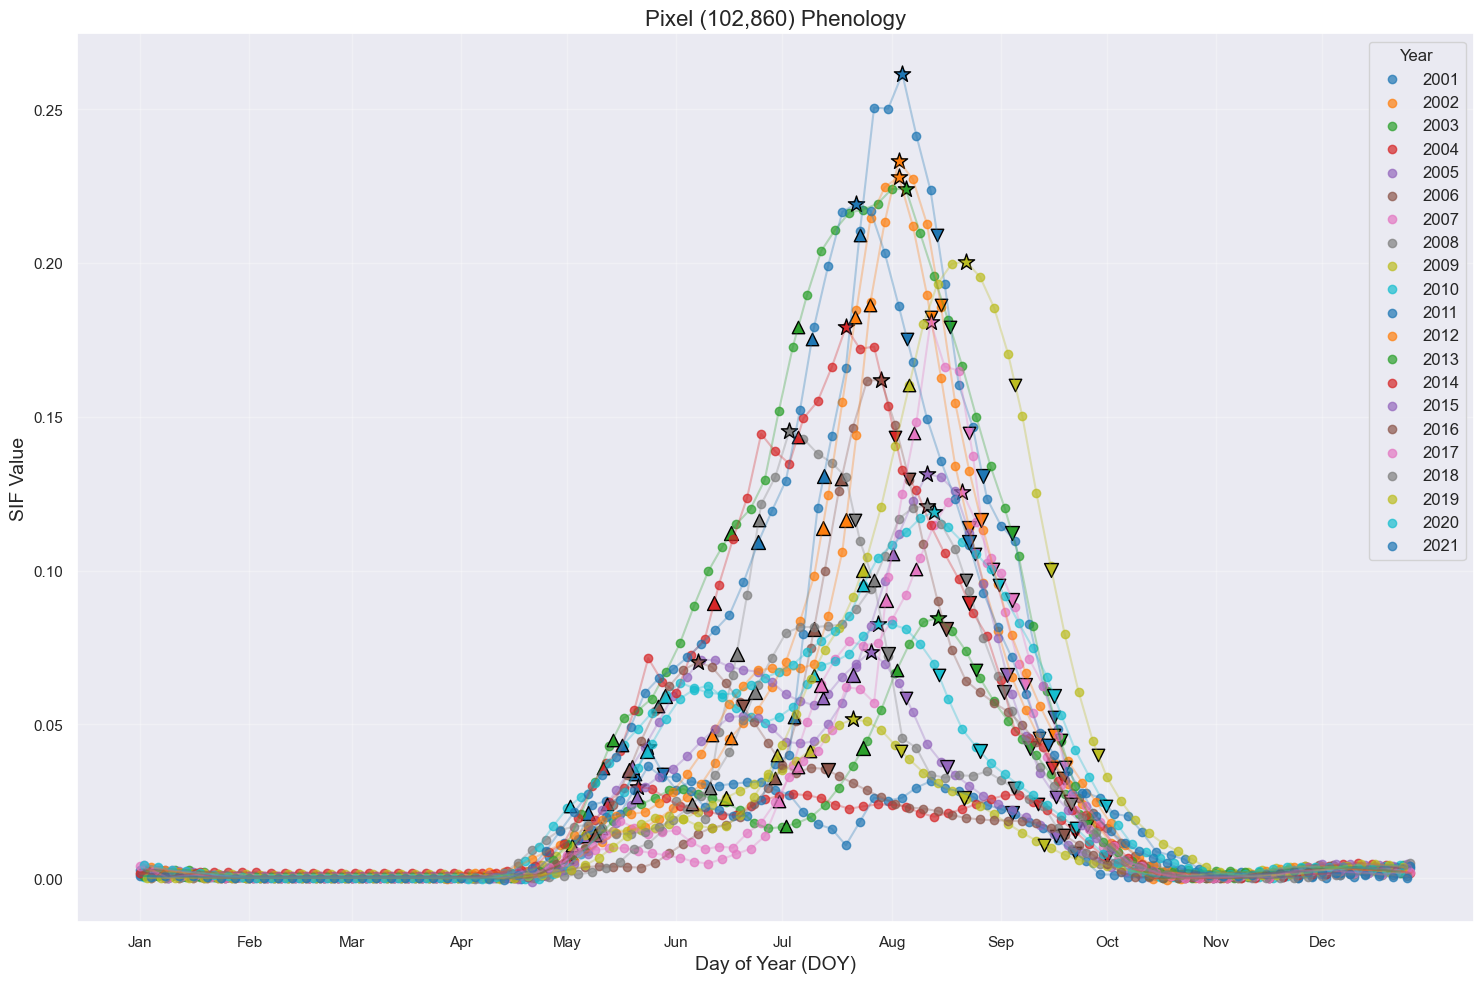

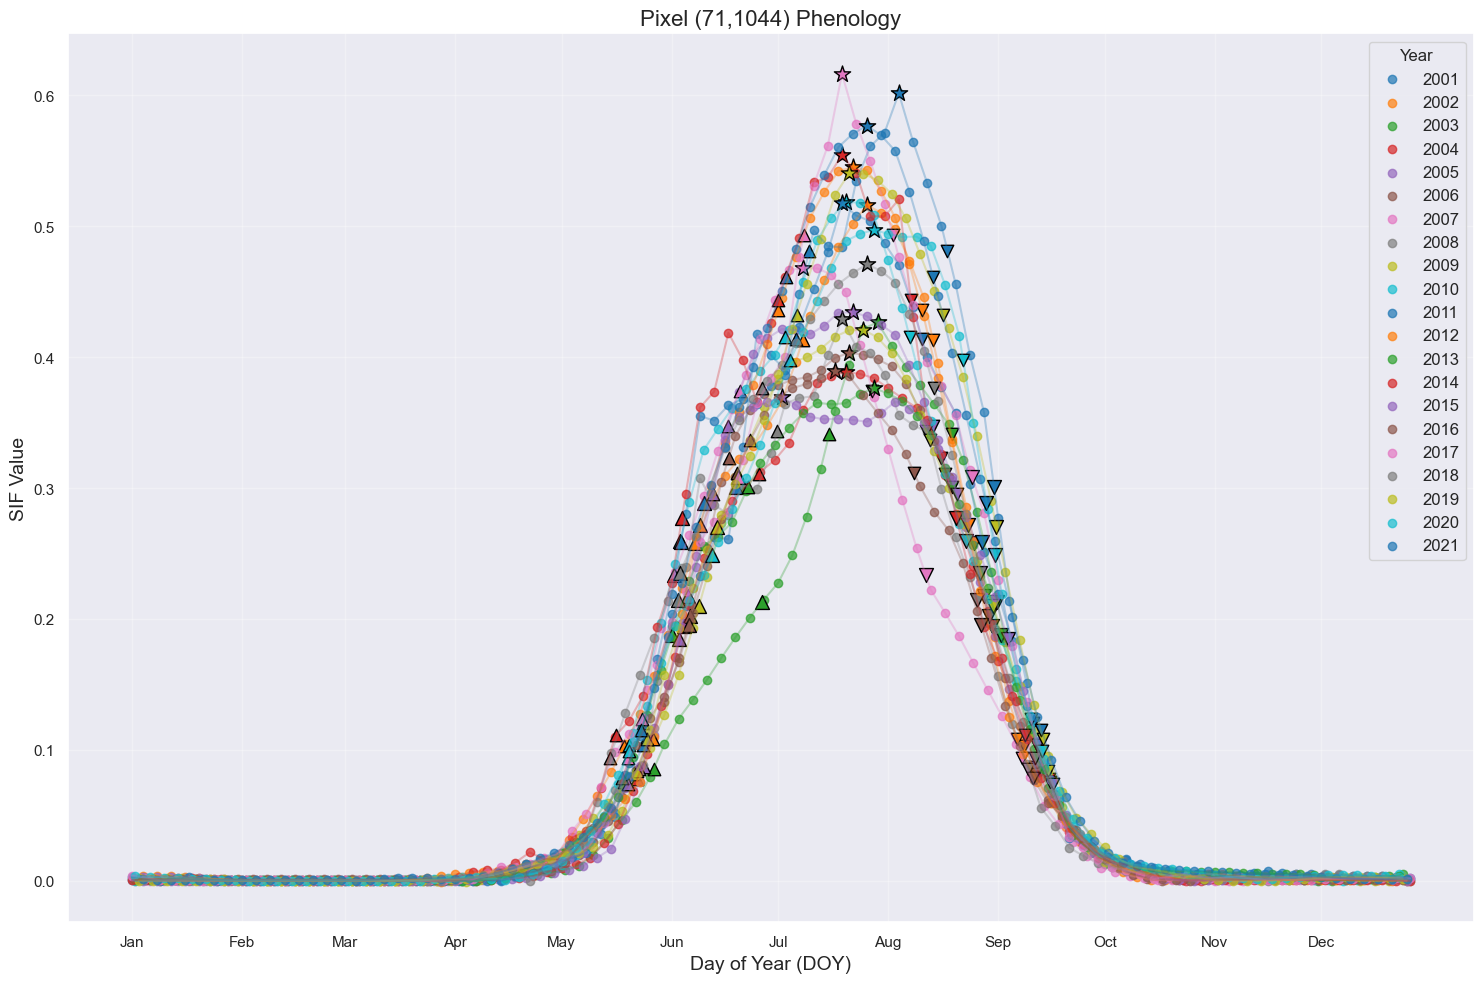

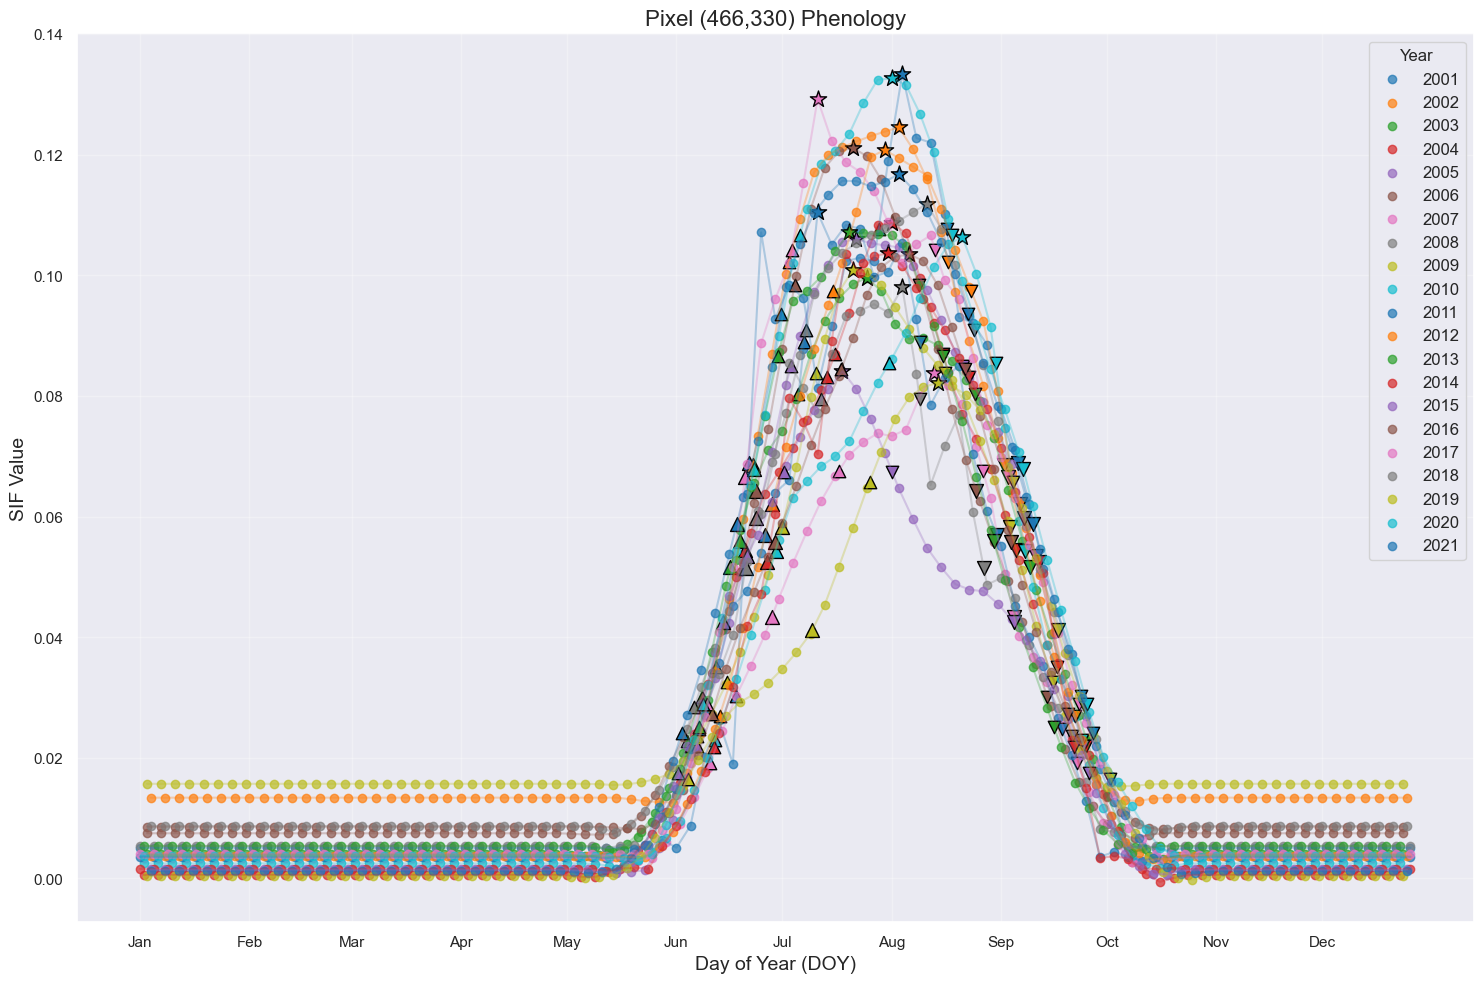

In [7]:
for year in years:
    year_dir = os.path.join(output_dir, str(year))
    os.makedirs(year_dir, exist_ok=True)
    
    for metric, data in phenology_results[year].items():
        filename = f"gosif_phenology_{year}_{metric}.tif"
        output_path = os.path.join(year_dir, filename)
        
        output_raster = template.copy()
        output_raster.values[0] = data
        
        output_raster.attrs.update({
            "long_name": f"GOSIF {metric} for year {year}"
        })
        
        output_raster.rio.to_raster(output_path)

# 为验证随机选择几个像素点绘制图形
print("生成验证图表...")
np.random.seed(42)
valid_pixels = []

for _ in range(5):
    y = np.random.randint(0, height)
    x = np.random.randint(0, width)

    valid_years = 0
    for year in years:
        if not np.isnan(phenology_results[year]['sos_50'][y, x]) and \
           not np.isnan(phenology_results[year]['eos_50'][y, x]):
            valid_years += 1
    
    if valid_years >= 3:
        valid_pixels.append((y, x))
        if len(valid_pixels) >= 3:
            break  # 找到3个点就足够

for i, (y, x) in enumerate(valid_pixels):
    plt.figure(figsize=(15, 10))
    
    for year in years:
        if np.isnan(phenology_results[year]['sos_50'][y, x]) or \
           np.isnan(phenology_results[year]['eos_50'][y, x]):
            continue
        
        year_data = yearly_data[year][:, y, x]
        year_doys = yearly_doys[year]
        valid_indices = np.where(~np.isnan(year_data))[0]
        
        year_idx = years.index(year)
        color = plt.cm.tab10(year_idx % 10)
        
        valid_data = year_data[valid_indices]
        valid_doys = np.array(year_doys)[valid_indices]
        plt.scatter(valid_doys, valid_data, color=color, alpha=0.7, label=f"{year}")
        
        sorted_indices = np.argsort(valid_doys)
        sorted_doys = valid_doys[sorted_indices]
        sorted_values = valid_data[sorted_indices]
        plt.plot(sorted_doys, sorted_values, color=color, alpha=0.3)
        
        sos_20 = phenology_results[year]['sos_20'][y, x]
        sos_50 = phenology_results[year]['sos_50'][y, x]
        sos_80 = phenology_results[year]['sos_80'][y, x]
        eos_20 = phenology_results[year]['eos_20'][y, x]
        eos_50 = phenology_results[year]['eos_50'][y, x]
        eos_80 = phenology_results[year]['eos_80'][y, x]
        peak_doy = phenology_results[year]['peak_doy'][y, x]
        
        min_value = phenology_results[year]['min_value'][y, x]
        amplitude = phenology_results[year]['amplitude'][y, x]
        
        sos_20_value = min_value + 0.2 * amplitude
        sos_50_value = min_value + 0.5 * amplitude
        sos_80_value = min_value + 0.8 * amplitude
        eos_80_value = min_value + 0.8 * amplitude
        eos_50_value = min_value + 0.5 * amplitude
        eos_20_value = min_value + 0.2 * amplitude
        
        if not np.isnan(sos_20):
            plt.scatter(sos_20, sos_20_value, color=color, marker='^', s=80, edgecolor='black')
        if not np.isnan(sos_50):
            plt.scatter(sos_50, sos_50_value, color=color, marker='^', s=100, edgecolor='black')
        if not np.isnan(sos_80):
            plt.scatter(sos_80, sos_80_value, color=color, marker='^', s=80, edgecolor='black')
        
        if not np.isnan(eos_80):
            plt.scatter(eos_80, eos_80_value, color=color, marker='v', s=80, edgecolor='black')
        if not np.isnan(eos_50):
            plt.scatter(eos_50, eos_50_value, color=color, marker='v', s=100, edgecolor='black')
        if not np.isnan(eos_20):
            plt.scatter(eos_20, eos_20_value, color=color, marker='v', s=80, edgecolor='black')
        
        if not np.isnan(peak_doy):
            plt.scatter(peak_doy, phenology_results[year]['peak_value'][y, x], color=color, marker='*', s=150, edgecolor='black')
    
    plt.title(f'Pixel ({y},{x}) Phenology', fontsize=16)
    plt.xlabel('Day of Year (DOY)', fontsize=14)
    plt.ylabel('SIF Value', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(title='Year', fontsize=12)
    
    month_doys = [datetime(2000, month, 1).timetuple().tm_yday for month in range(1, 13)]
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    plt.xticks(month_doys, month_names)
    
    plt.tight_layout()
    plt.savefig(f'pixel_{y}_{x}_phenology.png', dpi=300)
    plt.show()
